## Single-delayed inverted pendulum example

The parameters: `τ`=$\frac{\sqrt2}{4}$ and $b=1.5$ are fixed, while parameter $a$ is varied.

In this demo, we will be looking at an inverted pendulum example, which models the motion of a pendulum that is trying to remain upright. For this demo we'll use the simplified system given by the delay differential equation (DDE) system, similar to that given in (Krauskopf, Sieber 2023):
```math
\begin{align}
  \dot{x}&= v(t)\\
  \dot{v}&= \sin(x(t)) - ax(t- \tau) -bv(t-\tau)
\end{align}
```
where $x(t)$ is the angle by which the pendulum deviates from its upright positions, $v(t)$ is the angular velocity and where $\tau$ is the delay is the time taken between the pendulum starting to fall/lean and the reaction to start righting the pendulum.

The following packages and functions are needed:

In [1]:
using CairoMakie
using LinearAlgebra
include("../DDETools/DDETools.jl")
using .DDETools
include("invpend_1delay.jl") #RHS of single delay inverted pendulum example
include("inpend1tau.jl") #Delay function for inverted pendulum example


inpend1tau (generic function with 1 method)

# Equilibria branches

We begin this demo by finding the equilibira branches:

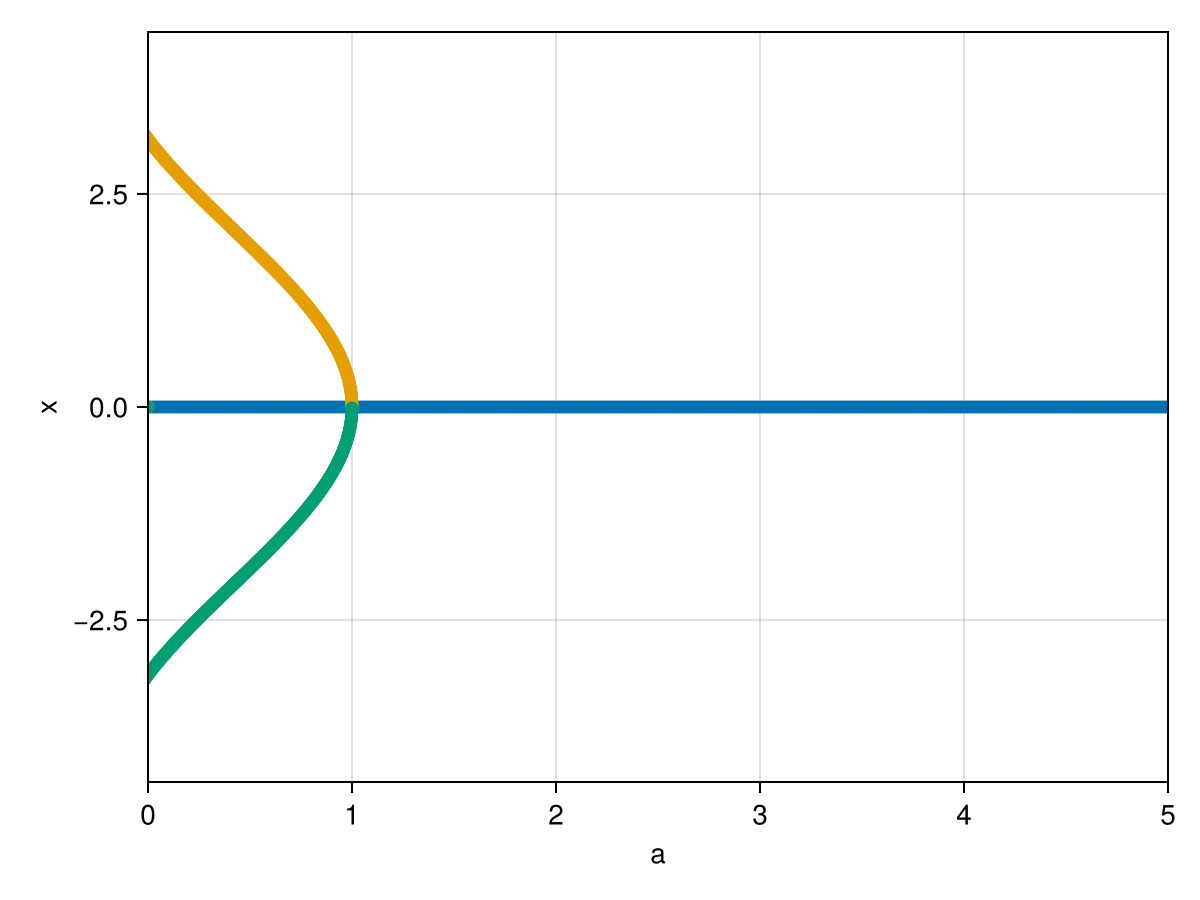

In [2]:
a=0.0 #parameter a - starts at 0 as this is the parameter we're varying over
b=1.5 #parameter b - fixed 
tau=sqrt(2)/4 #delay τ
nd=1 #number of delays (single delay so nd=1)

#Now we looking at finding the equilibria branches
y01,f_equ=DDETools.create_ststfunc(invpend_1delay,[0.0,0],[a,b,tau],nd,par_indx=1) #pars_indx=1 as parameter a (the parameter we're varying) is the first parameter
#The above outputs the initial guess for x,v and parameter 'a' and the equilibrium function

ylist1,ytan1=DDETools.track_curve(f_equ,y01,[0.0,0,1],nmax=1000) #initial tangent changes a (initial tangent=[0.0,0,1])
ylist2,ytan2=DDETools.track_curve(f_equ,y01,[1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in postive x direction
ylist3,ytan3=DDETools.track_curve(f_equ,y01,[-1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in negative x direction

#Below plots the equilibria branches
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a",ylabel="x")
scatter!(ax1,[u[3] for u in ylist1],[u[1] for u in ylist1])
scatter!(ax1,[u[3] for u in ylist2],[u[1] for u in ylist2])
scatter!(ax1,[u[3] for u in ylist3],[u[1] for u in ylist3])
xlims!(ax1,[0.0,5])
fig1

In [3]:
#Check that the outputs are equilibria (f(x*,x*)=0)
u0ex1=ylist2[5][1:2] #equilibrium point values for x value
pex1=ylist2[5][3]# (varied) parameter - in this case a - that allows for u0ex1 to be an equilibrium point
u0vec1=[ylist2[5][1:2] for _ in 1:nd+1]
invpend_1delay(u0vec1,[ylist2[5][3],b,tau]) #check this outputs 0's (it should as u0ex1 is an equilibrium point)

2-element Vector{Float64}:
 -1.7993480001044521e-28
  2.699022000156678e-28

# Stability - approximating using large matrix method

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past of DDEs. For this part of the example the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func_matrix ``` utilises this method and has a first output of 1 is the equilibrium point if stable and has 0 if it is unstable. Below we find the stability of all the equilibria and plot them:

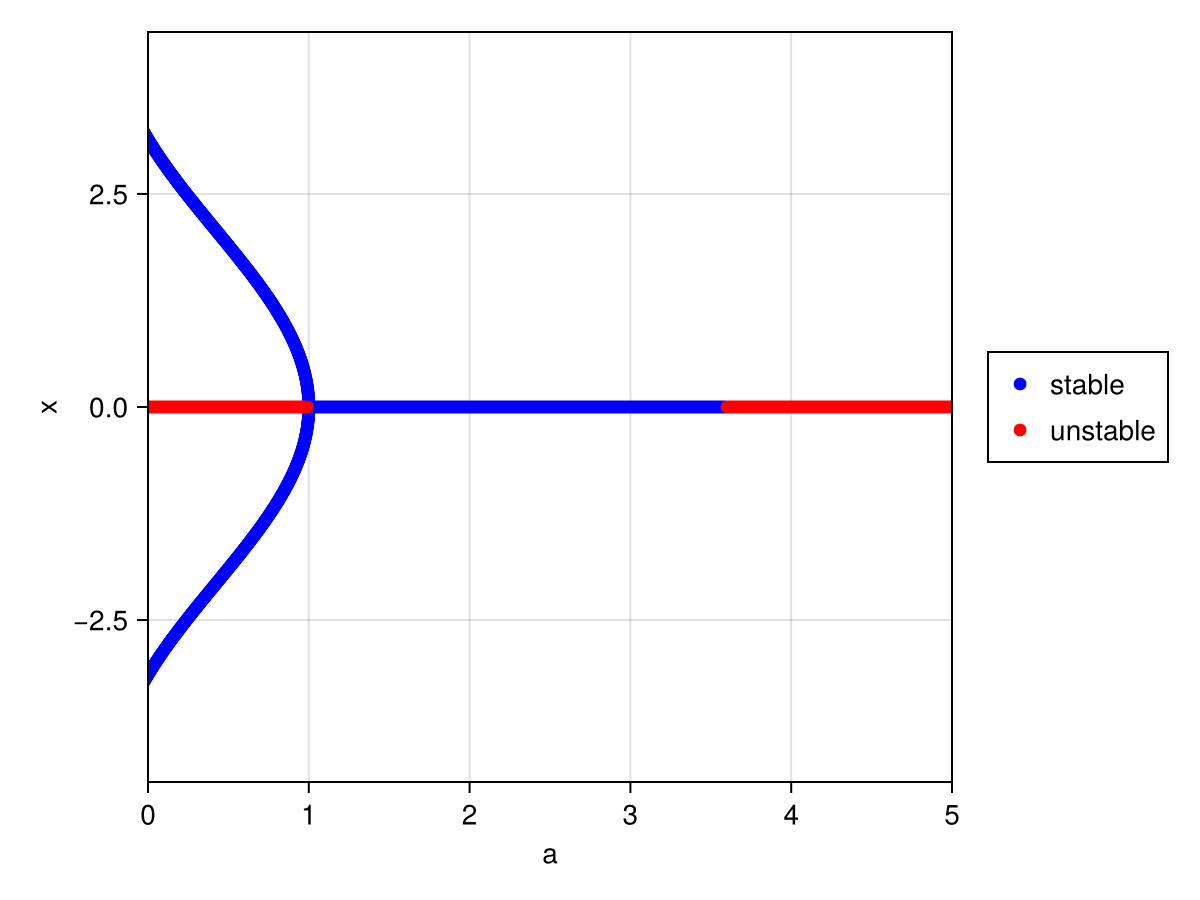

In [4]:
xmat1=hcat([u[1] for u in ylist1],[u[2] for u in ylist1]) #finds the values of x and v for the first equilibrium branch
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)]#creates a vector of vectors of all the first equilibria branch points
xmat2=hcat([u[1] for u in ylist2],[u[2] for u in ylist2]) #finds the values of x and v for the second equilibrium branch
xlist2=[xmat2[i,:] for i in 1:size(xmat2,1)]#creates a vector of vectors of all the second equilibria branch points
xmat3=hcat([u[1] for u in ylist3],[u[2] for u in ylist3]) #finds the values of x and v for the third equilibrium branch
xlist3=[xmat3[i,:] for i in 1:size(xmat3,1)]#creates a vector of vectors of all the third equilibria branch points

plist1=[u[3] for u in ylist1] #A vector of the values of a for the first equilibrium branch
plist2=[u[3] for u in ylist2] #A vector of the values of a for the second equilibrium branch
plist3=[u[3] for u in ylist3] #A vector of the values of a for the third equilibrium branch

xlist=vcat(xlist1,xlist2,xlist3) #combines all the equilibirium points into one vector
plist=vcat(plist1,plist2,plist3) #combines all values of parameter a into one vector

neq=length(plist) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 1:neq
    stab[i]=DDETools.stab_func_matrix(invpend_1delay,inpend1tau,xlist[i],[plist[i]],[a,b,tau],[1],nd,doprint=0) #returns stability of the equilibiria (Outputs 1 for stable and 0 for unstable)
end 

stable=(stab.==1.0)#highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="a",ylabel="x")
scatter!(ax2,plist[stable],[u[1] for u in xlist[stable]],label="stable",color="blue")
scatter!(ax2,plist[unstable],[u[1] for u in xlist[unstable]],label="unstable",color="red")
Legend(fig2[1,2], ax2, merge=true)
xlims!(ax2,[0.0,5])
fig2

# Stability using Breda et al (2009) method

The function ```stab_func_DDE``` uses the method described in (Breda et al 2009) to find the stability and the eigenvalues (if asked, the eigenvectors) of an equilibrium point. For more information on this function, see the "Stability_finding_for_DDEs.ipynb" notebook  located in the "DDE_stability_breda_et_al" folder. To use ```stab_func_DDE```, the partial derivative matrices $A_0, A_1$ need to be found for the equilibrium point(s). These matrcies can be found manually (if possible) or by using ```f_deriv```. In this example we'll use ```f_deriv``` so we can loop over all equilibrium points.

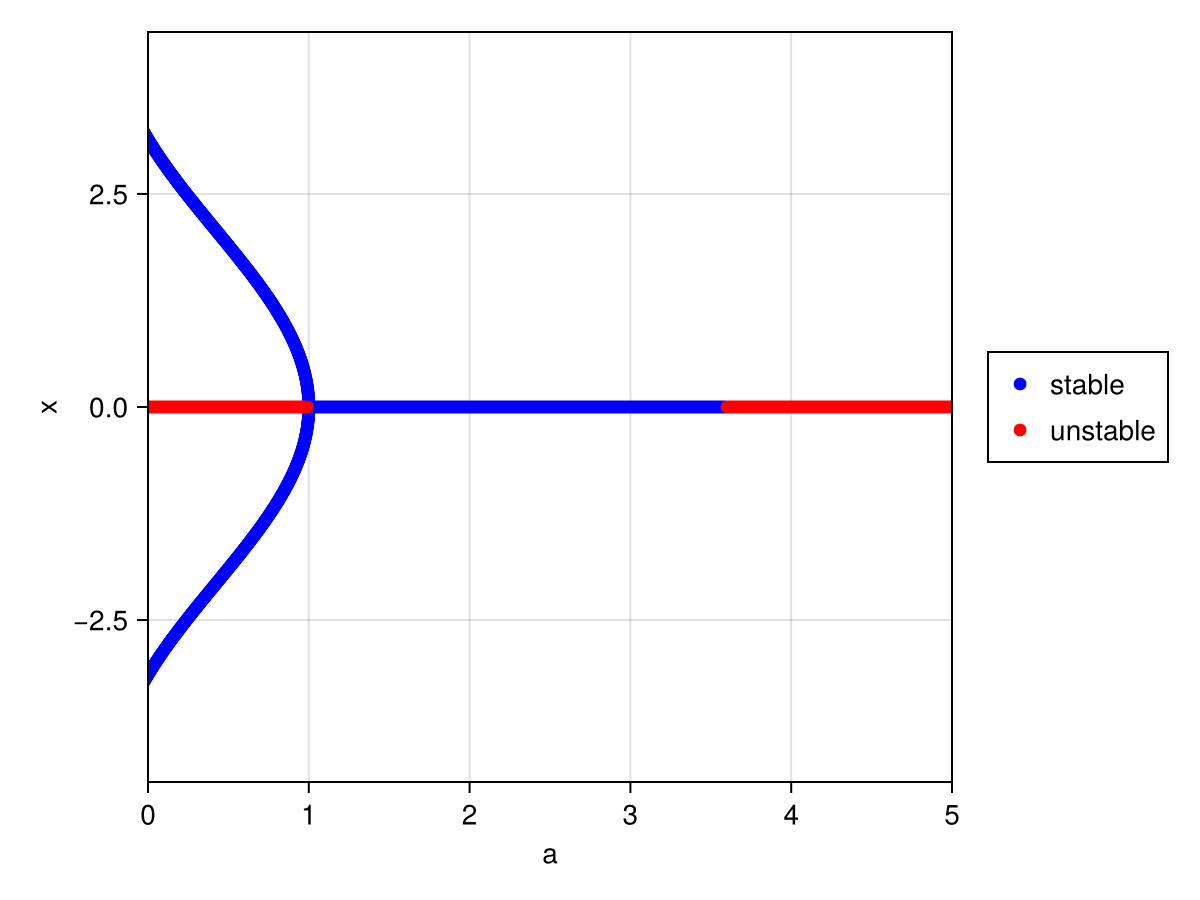

In [5]:
N=50 #so there are 51 interpolation points
neq=length(plist) #number of equilibrium points we're finding the stability of
stab_DDE=fill(NaN,neq)

for i in 1:neq
    A0=DDETools.f_deriv(invpend_1delay,xlist[i],[plist[i],b,tau],nd,nx=1) #finds partial derivative matrix with respect to x(t)
    A1=DDETools.f_deriv(invpend_1delay,xlist[i],[plist[i],b,tau],nd,nx=2) #finds partial derivative matrix with respect to x(t-τ)
    stab_DDE[i],=DDETools.stab_func_DDE([A0,A1],[tau],N) #gives stability of each equilibrium point
end 

stableDDE=(stab_DDE.==1.0)#highlights indices of stable points (indicated by a 1 in stable vector)
unstableDDE=(stab_DDE.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="a",ylabel="x")
scatter!(ax3,plist[stableDDE],[u[1] for u in xlist[stableDDE]],label="stable",color="blue")
scatter!(ax3,plist[unstableDDE],[u[1] for u in xlist[unstableDDE]],label="unstable",color="red")
Legend(fig3[1,2], ax3, merge=true)
xlims!(ax3,[0.0,5])
fig3

Notice that the Breda et al method (given in ```stab_func_DDE```) is much quicker at finding stability than approximating it using a large matrix (method used in ```stab_func_matrix```).

# Hopf Bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conjugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. $\lambda=\pm \omega i$. We start finding the Hopf parameters by finding the initial guess of the $a$ value for the Hopf bifurcation: 

Note that while the initial guess of $a$ for a Hopf bifurcation can be found using both ```stab_func_matrix``` and ```stab_func_DDE```, the true Hopf bifurcation can only be found when using the stability function ```stab_func_matrix``` as ```create_hopffunc``` has been made to, currently, only work for ```stab_func_matrix```. The code for finding the initial guesses of $a$ for the two different stability methods is given below:

In [6]:
#Hopf parameter guess from stab_func_matrix results
stab_indx=findfirst(isequal(1.0),stab)#finds where stability changes first time
unstab2_indx=findfirst(isequal(0.0),stab[stab_indx+1:end]) #finds where stability changes again
hopf_indx=stab_indx+unstab2_indx #index of the initial guess where Hopf bifurcation is
a_hopf_est=plist[hopf_indx] #parameter guess for Hopf bifurcation

3.5999999999999672

In [7]:
#Hopf parameter guess from stab_func_DDE results
stab_DDEindx=findfirst(isequal(1.0),stab_DDE)#finds where stability changes first time
unstab2_DDEindx=findfirst(isequal(0.0),stab_DDE[stab_DDEindx+1:end]) #finds where stability changes again
hopf_DDEindx=stab_DDEindx+unstab2_DDEindx #index of the initial guess where Hopf bifurcation is
a_hopf_DDEest=plist[hopf_DDEindx] #parameter guess for Hopf bifurcation

3.5999999999999672

Now we have an initial guess (taking the one obtained from ```stab_func_matrix```) for the Hopf parameters, we find the true parameter values:

In [8]:
yh01,fhopf=DDETools.create_hopffunc(invpend_1delay,inpend1tau,[a,b,tau],xlist[hopf_indx],[plist[hopf_indx]],[1],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and a estimates) and a function that contains the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=DDETools.newton(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The a value for hopf bifurcation: $a_hopf")
println("The ω value for hopf bifurcation: $om_hopf") #gives 1.8910.. which is about 0.6π which matches results found in (Krauskopf, Sieber 2023)

The initial guess for Hopf info: [0.0, 0.0, 0.00043671017633650354, 0.8838722840594124, -0.46772812055276247, 0.0, 1.8897121526201632, 3.5999999999999672]
The true information for the Hopf bifurcation: [0.0, 0.0, 9.543458063659452e-5, 0.8840075184102645, -0.46747263632951647, 0.00018047021417444485, 1.8910358590211405, 3.590806415288951]
converged?: true
The a value for hopf bifurcation: 3.590806415288951
The ω value for hopf bifurcation: 1.8910358590211405


In [9]:
println("The estimated a value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: $a_hopf_est")
println("The estimated a value for Hopf bifurcation using  stab_func_DDE is: $a_hopf_DDEest")
println("True a value for Hopf bifurcation given by stab_func_matrix: $a_hopf")

The estimated a value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: 3.5999999999999672
The estimated a value for Hopf bifurcation using  stab_func_DDE is: 3.5999999999999672
True a value for Hopf bifurcation given by stab_func_matrix: 3.590806415288951


# Pitchfork bifurcation

The code below finds the parameter value of $a$ such that an eigenvalue $\lambda=0$ exists. Note that in this project the corresponding $a$ value can only be found using the large matrix stability method (```stab_func_matrix```), which is used to get the eigenvalues and eigenvectors.

In [10]:
y0f1,ffold1=DDETools.create_foldfunc(invpend_1delay,inpend1tau,[a,b,tau],[0.0,0],[1.4],[1],1) #returns initial guess for the fold parameters and a function that contains the formula for finding a fold
yff1,convf1,=DDETools.newton(ffold1,y0f1) #finds value of a for fold for fixed b=1.5

a_fold=yff1[end]
x_fold=yff1[1]

println("The information for the fold bifurcation: $yff1")
println("The value of 'a' that a fold occurs at is: $a_fold")

The information for the fold bifurcation: [0.0, 0.0, -1.0, -4.077079421841274e-25, 0.0, 0.0, 0.9999999999833333]
The value of 'a' that a fold occurs at is: 0.9999999999833333


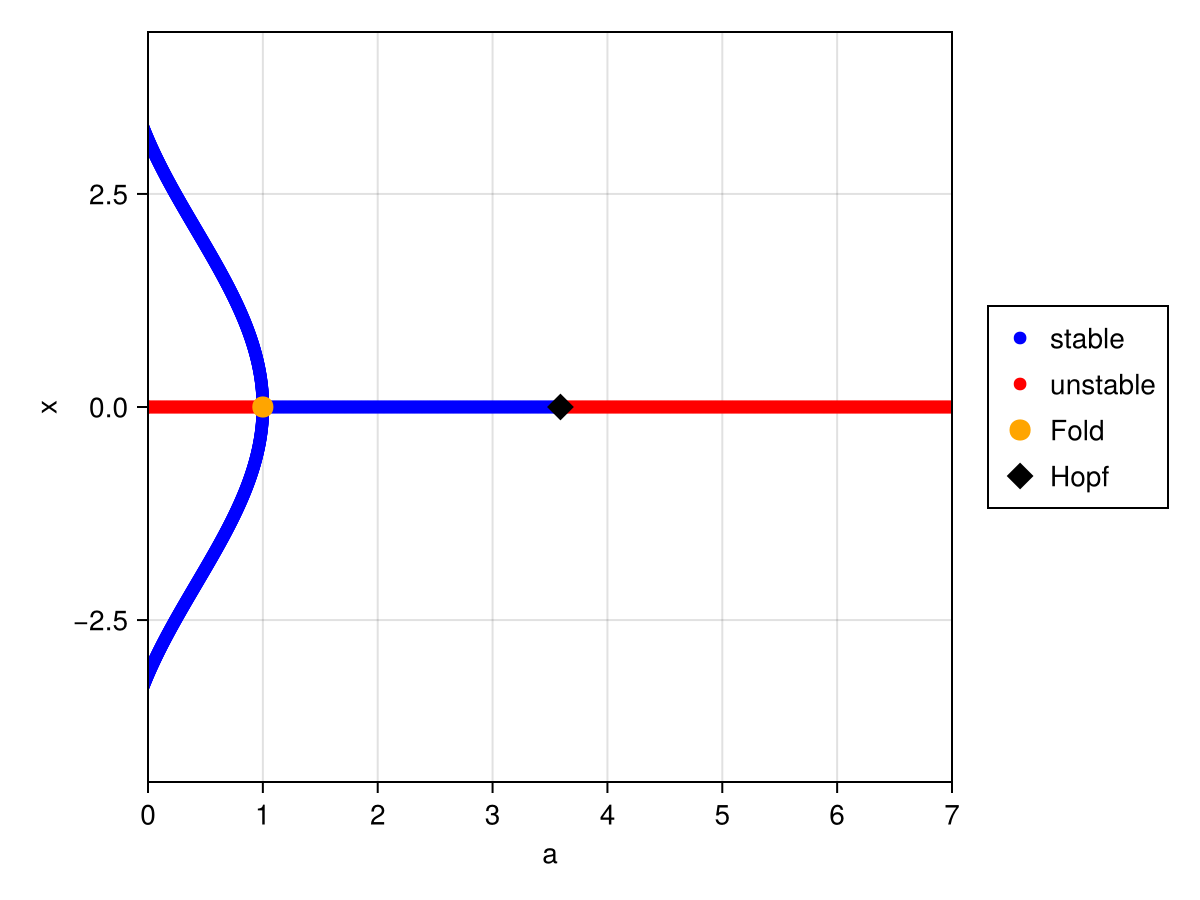

In [11]:
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a",ylabel="x")
scatter!(ax4,plist[stable],[u[1] for u in xlist[stable]],label="stable",color="blue")
scatter!(ax4,plist[unstable],[u[1] for u in xlist[unstable]],label="unstable",color="red")
scatter!(ax4,a_fold, x_fold, label="Fold", color=:orange, marker=:circle, markersize=:15)
scatter!(ax4,a_hopf, x_hopf, label="Hopf", color=:black, marker=:diamond, markersize=:15)
Legend(fig4[1,2], ax4, merge=true)
xlims!(ax4,[0.0,7])
fig4

While this code produces an $a$ value for a fold bifurcation, however, the bifurcation at $a$=1 is actually a pitchfork bifurcation (rather than a fold bifurcation) due to the reflection symmetry.

# Continutation over ($a,b$)-plane

We continue the bifurcation points in the $a$ and $b$ parameter plane:

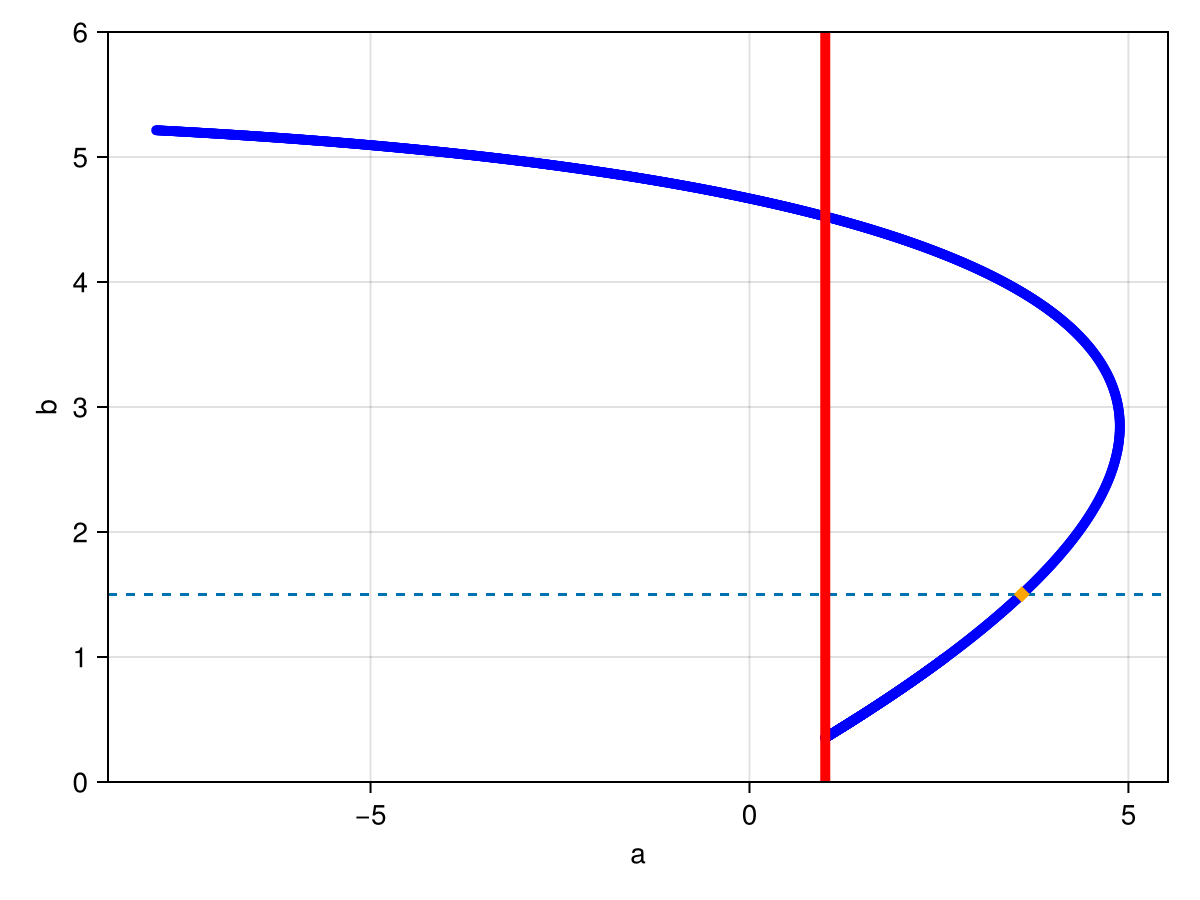

In [12]:
yheq01,fhopfeq1=DDETools.create_hopffunc(invpend_1delay,inpend1tau,[a_hopf,0,tau],[0.0,0],[a_hopf,0],[1,2],nd) #initialises hopf function and initial guess for Hopf information including a≈3.59 and b=0
yheqlist1,heqtan1=DDETools.track_curve(fhopfeq1,yheq01,[0.0,0,0,0,0,0,0,-1,-1],nmax=2000) #tracks over a and b plane

#Below marks the Hopf bifurcation for fixed b=1.5
a_vals=[u[end-1] for u in yheqlist1]
b_vals=[u[end] for u in yheqlist1]
b1_5indx=argmin(abs.([u[end] for u in yheqlist1].-1.5))
a1=a_vals[b1_5indx]
b1=b_vals[b1_5indx]

#Plot of continuation/tracking in (a,b) plane
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="a",ylabel="b")
scatter!(ax5,[u[end-1] for u in yheqlist1[2:end]],[u[end] for u in yheqlist1[2:end]],color="blue",markersize=:7)
hlines!(ax5,1.5,linestyle=:dash)
scatter!(ax5,a1,b1,marker=:diamond,color=:orange) # Hopf bifurcation for fixed b=1.5
vlines!(ax5,1,linestyle=:solid, linewidth=:5,color=:red) #red line represents the fact that a pitchfork bifurcation occurs at a=1 for all b values
ylims!(ax5,[0,6])
fig5

# References

1. D. Breda, S. Maset and R. Vermiglio . *TACE-DDE: a Tool for Robust Analysis and Characteristic Equations for Delay Differential Equations*, volume 388, pages 145-155, 2009
2.  B. Krauskopf and J. Sieber. *Bifurcation Analysis of Systems With Delays: Methods and Their Use in Applications*, pages 195-245. Springer International Publishing, Cham, 2023